In [177]:
# Import of relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# modelling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_predict, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from xgboost import plot_importance


#metrics
from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import fbeta_score, make_scorer

plt.style.use('seaborn')

RSEED = 45

In [215]:
# # load the data set from CSV file
HDD_ST4000DM000= pd.read_csv('../src/data/data/processed/ST4000DM000_history_total_preprocessed.csv', parse_dates=['date'])

In [216]:
HDD_ST4000DM000.head()

,date,serial_number,model,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw,date_failure,countdown
0,2020-09-18,Z304JG86,ST4000DM000,0,115.0,93783288.0,91.0,13.0,100.0,0.0,...,100.0,0.0,100.0,0.0,0.0,42329.0,5.519570e+10,2.709359e+11,2020-11-07,50
1,2020-09-18,S301GMGZ,ST4000DM000,0,113.0,55185864.0,91.0,13.0,100.0,0.0,...,100.0,16.0,100.0,16.0,0.0,42778.0,5.982921e+10,2.557590e+11,2021-05-31,255
2,2020-09-18,S300YQTN,ST4000DM000,0,118.0,170426904.0,94.0,6.0,100.0,0.0,...,100.0,16.0,100.0,16.0,0.0,46671.0,6.363719e+10,2.580255e+11,2021-05-28,252
3,2020-09-18,Z302T8AB,ST4000DM000,0,117.0,119029336.0,92.0,27.0,100.0,0.0,...,100.0,0.0,100.0,0.0,0.0,43845.0,6.252935e+10,2.568232e+11,2020-12-04,77
4,2020-09-18,Z302SXFH,ST4000DM000,0,108.0,18778216.0,92.0,8.0,100.0,0.0,...,100.0,0.0,100.0,0.0,57.0,44350.0,6.250835e+10,2.357636e+11,2020-09-22,4


In [217]:
# Define pollution labels and range cut offs
Failing_labels = ["Fail in 30 days", "Will work more than 30 days"]
Failing_bins = [-1, 30, 800]

#Create new Failing_labels variable
HDD_ST4000DM000["Failing_labels"] = pd.cut(HDD_ST4000DM000["countdown"], bins = Failing_bins, labels=Failing_labels)

In [218]:
def classification_target(cols):
    """function to adjust the previously created "fail_30" column and transform data based on the previous data into 0 or 1
    if value is <= 30, the value is transformed into 1
    if value is > 30, the value is transformed into 0

    Args:
        cols: takes as an argument the panads column specified before the apply method

    Returns:
        int: 0 or 1 based on the previous information
    """
    classification = cols[0]

    if classification <= 30:
        return 1
    if classification > 30:
        return 0

In [219]:
HDD_ST4000DM000['Failing_as_int'] = HDD_ST4000DM000[['countdown']].apply(classification_target, axis=1)

In [220]:
HDD_ST4000DM000.Failing_as_int.dtype

dtype('int64')

In [221]:
HDD_ST4000DM000.head()

,date,serial_number,model,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_198_normalized,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw,date_failure,countdown,Failing_labels,Failing_as_int
0,2020-09-18,Z304JG86,ST4000DM000,0,115.0,93783288.0,91.0,13.0,100.0,0.0,...,100.0,0.0,0.0,42329.0,5.519570e+10,2.709359e+11,2020-11-07,50,Will work more than 30 days,0
1,2020-09-18,S301GMGZ,ST4000DM000,0,113.0,55185864.0,91.0,13.0,100.0,0.0,...,100.0,16.0,0.0,42778.0,5.982921e+10,2.557590e+11,2021-05-31,255,Will work more than 30 days,0
2,2020-09-18,S300YQTN,ST4000DM000,0,118.0,170426904.0,94.0,6.0,100.0,0.0,...,100.0,16.0,0.0,46671.0,6.363719e+10,2.580255e+11,2021-05-28,252,Will work more than 30 days,0
3,2020-09-18,Z302T8AB,ST4000DM000,0,117.0,119029336.0,92.0,27.0,100.0,0.0,...,100.0,0.0,0.0,43845.0,6.252935e+10,2.568232e+11,2020-12-04,77,Will work more than 30 days,0
4,2020-09-18,Z302SXFH,ST4000DM000,0,108.0,18778216.0,92.0,8.0,100.0,0.0,...,100.0,0.0,57.0,44350.0,6.250835e+10,2.357636e+11,2020-09-22,4,Fail in 30 days,1


### Train / Test split

#### Checking again for duplicates and get rid of them

In [222]:
#checking for duplicates
a = HDD_ST4000DM000.query('failure == 1')['serial_number'].to_list()
print(len(a))
a_set = set(a)
print(len(a_set))
a_dup=[]
for serial in a_set:
    a.remove(serial)
print(a)

610
608
['Z302SQFX', 'Z303VDR4']


In [223]:
# query the duplicates (SAME SERIALS WITH FAIL = 1) and add them to a list (there are only 2 of each)
duplicate = HDD_ST4000DM000.query("serial_number == 'Z302SQFX' and failure == 1").index.values.tolist()
duplicate_2 = HDD_ST4000DM000.query("serial_number == 'Z303VDR4' and failure == 1").index.values.tolist()
duplicate_2 

#remove last item from created lists
drop_rows = duplicate.pop() 
drop_rows2 = duplicate_2.pop()

#drop the created rows
HDD_ST4000DM000.drop(drop_rows, axis=0, inplace=True)
HDD_ST4000DM000.drop(drop_rows2, axis=0, inplace=True)

In [224]:
# We have a look on the all the duplicates identified by the Serial column
HDD_ST4000DM000["serial_number"].duplicated()
duplicate_id = HDD_ST4000DM000.groupby("serial_number").size().to_frame('Count').reset_index()
duplicate_id = duplicate_id.sort_values('Count', ascending=False)
duplicate_id.head(10)

,serial_number,Count
333,Z304GSQ0,1096
511,Z305AQQP,1095
211,Z302SWBN,1091
593,Z305K296,1089
607,Z307XHRJ,1087
153,W301BY50,1086
353,Z304HWNT,1085
599,Z305MM0G,1084
157,Z3026ZSL,1084
453,Z304KQXL,1084


In [225]:
#Preparing a DF based on unique Serial numbers for filtering and splitting the data in a proper way
df1 = pd.DataFrame(HDD_ST4000DM000.serial_number.unique(), columns=['Serial_unique'])

df1

,Serial_unique
0,Z304JG86
1,S301GMGZ
2,S300YQTN
3,Z302T8AB
4,Z302SXFH
...,...
603,Z305FDYS
604,Z304K6EG
605,S300ZV6H
606,Z302A12A


In [226]:
#create a train/test split with serials based on dummies (80/20)
#creat a list of the separated serials + create a pd.series
RSEED = 200
serial_number_train, serial_number_test, dummy_train, dummy_test = train_test_split(df1['Serial_unique'], df1['Serial_unique'], test_size=0.2, random_state=RSEED)

serial_number_train = pd.Series(serial_number_train)
serial_number_test = pd.Series(serial_number_test)

In [227]:
#Generate the Train and test data based on the splitted serials
df_train = HDD_ST4000DM000[HDD_ST4000DM000["serial_number"].isin(serial_number_train)]
y_train = df_train["Failing_as_int"]
X_train = df_train.drop(["Failing_as_int", "countdown"], axis=1)

# X_train.query('failure == 1').count()
# X_train.query('failure == 1').nunique()


In [228]:
df_test = HDD_ST4000DM000[HDD_ST4000DM000["serial_number"].isin(serial_number_test)]
y_test = df_test["Failing_as_int"]
X_test = df_test.drop(["Failing_as_int", "countdown"], axis=1)

<AxesSubplot:xlabel='Failing_as_int', ylabel='count'>

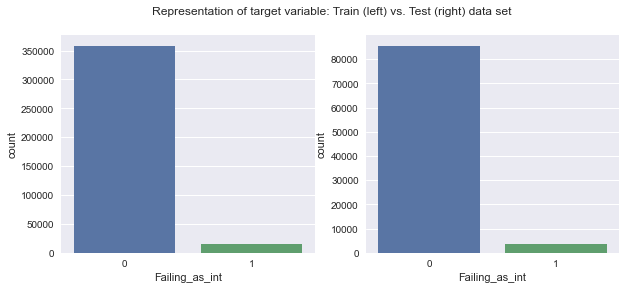

In [229]:
# Visualize y_train and y_test after splitting
fig, axes = plt.subplots(1,2, figsize=(10, 4))
fig.suptitle("Representation of target variable: Train (left) vs. Test (right) data set")
sns.countplot(x=y_train, ax=axes[0])
sns.countplot(x=y_test, ax=axes[1])

In [230]:
# Show dimensions of train and testing data
print(X_train.shape)
print(X_test.shape)

(373587, 42)
(89377, 42)


In [231]:
X_train.head(5)

,date,serial_number,model,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw,date_failure,Failing_labels
0,2020-09-18,Z304JG86,ST4000DM000,0,115.0,93783288.0,91.0,13.0,100.0,0.0,...,100.0,0.0,100.0,0.0,0.0,42329.0,5.519570e+10,2.709359e+11,2020-11-07,Will work more than 30 days
2,2020-09-18,S300YQTN,ST4000DM000,0,118.0,170426904.0,94.0,6.0,100.0,0.0,...,100.0,16.0,100.0,16.0,0.0,46671.0,6.363719e+10,2.580255e+11,2021-05-28,Will work more than 30 days
3,2020-09-18,Z302T8AB,ST4000DM000,0,117.0,119029336.0,92.0,27.0,100.0,0.0,...,100.0,0.0,100.0,0.0,0.0,43845.0,6.252935e+10,2.568232e+11,2020-12-04,Will work more than 30 days
4,2020-09-18,Z302SXFH,ST4000DM000,0,108.0,18778216.0,92.0,8.0,100.0,0.0,...,100.0,0.0,100.0,0.0,57.0,44350.0,6.250835e+10,2.357636e+11,2020-09-22,Fail in 30 days
5,2020-09-18,Z3058LG6,ST4000DM000,0,113.0,51919976.0,92.0,9.0,100.0,0.0,...,100.0,152.0,100.0,152.0,0.0,41327.0,4.235107e+10,2.489969e+11,2020-10-01,Fail in 30 days


## Preparing the data

In [232]:
#prepare x for modelling (dropping columns)
#list only columns with the string "mean"

Grouping_columns = list(X_train.columns[X_train.columns.str.contains("smart" and "raw")])
#X_train = X_train.drop(['date_failure', 'model', 'serial_number', 'date'], axis=1)

X_train = X_train[Grouping_columns]
X_test = X_test[Grouping_columns]

In [233]:
X_train.isnull().sum()

smart_1_raw      0
smart_4_raw      0
smart_5_raw      0
smart_7_raw      0
smart_9_raw      0
smart_12_raw     0
smart_183_raw    0
smart_184_raw    0
smart_187_raw    0
smart_188_raw    0
smart_189_raw    0
smart_190_raw    0
smart_192_raw    0
smart_193_raw    0
smart_194_raw    0
smart_197_raw    0
smart_198_raw    0
smart_199_raw    0
smart_240_raw    0
smart_241_raw    0
smart_242_raw    0
dtype: int64

### Scaling based on X_train

In [234]:
# Standardizing the data; MinMax/Standard
scaler_X_train =MinMaxScaler()
scaler_X_train.fit(X_train.select_dtypes(np.number))
def scale_data_based_on_X_train(train, test):
    '''
    MinMaxScaler to fit and transform train data and transform test data
    '''
    train_scaled = scaler_X_train.transform(train.select_dtypes(np.number)) # takes only numerical columns (drop 'location' and 'ID')
    test_scaled = scaler_X_train.transform(test.select_dtypes(np.number))
    return train_scaled, test_scaled

In [235]:
# Scaling the data based on X_train
X_train_scaled, X_test_scaled = scale_data_based_on_X_train(X_train, X_test)

In [236]:
X_train_scaled

array([[0.3841399 , 0.07272727, 0.        , ..., 0.66945699, 0.68144986,
        0.23745559],
       [0.69807505, 0.03030303, 0.        , ..., 0.76561254, 0.81785766,
        0.22231702],
       [0.48754867, 0.15757576, 0.        , ..., 0.7030295 , 0.79995586,
        0.22090725],
       ...,
       [0.32929474, 0.0969697 , 0.        , ..., 0.67906812, 0.75222911,
        0.7023046 ],
       [0.8403737 , 0.07272727, 0.        , ..., 0.62184427, 0.63988799,
        0.24956179],
       [0.83460556, 0.06666667, 0.        , ..., 0.69902117, 0.77399816,
        0.20645513]])

## Building and Testing the models

### First try of a few basic models

In [237]:
features_baseline = ['smart_5_raw', 'smart_183_raw', 'smart_187_raw', 'smart_184_raw']

In [238]:
X_train[features_baseline]

,smart_5_raw,smart_183_raw,smart_187_raw,smart_184_raw
0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,2.0,0.0,0.0
5,0.0,3.0,14.0,0.0
...,...,...,...,...
462961,0.0,0.0,0.0,0.0
462962,0.0,0.0,0.0,0.0
462963,0.0,0.0,0.0,0.0
462964,0.0,0.0,0.0,0.0


In [239]:
y_train

0         0
2         0
3         0
4         1
5         1
         ..
462961    0
462962    0
462963    0
462964    0
462965    0
Name: Failing_as_int, Length: 373587, dtype: int64

In [240]:
# Define fbeta score with higher weighted recall
ftwo_scorer = make_scorer(fbeta_score, beta=2)

# Define dictionary with several interesting metrics
scorer_dict = {"ftwo_scorer": make_scorer(fbeta_score, beta=2), "accuracy": "accuracy", "precision": "precision", "recall": "recall"}


In [241]:
def model_evaluation(clf, scoring, X_train, y_train):
    
    results = {}
    scores = cross_validate(clf, X_train, y_train, scoring=scoring, cv=5, n_jobs=-1)
    results = {key: [value.mean().round(4), value.std().round(4)] for key, value in scores.items()}
    
    del results['fit_time']
    del results['score_time']
    
    return results

In [242]:
# Test different types of models
list_of_clf = [LogisticRegression(), KNeighborsClassifier(), SVC(), SGDClassifier(), GaussianNB(),  DecisionTreeClassifier(random_state=42)]
for clf in list_of_clf:
    results = model_evaluation(clf, scorer_dict, X_train[features_baseline], y_train)
    print(clf)
    print("Accuracy  (mean, std):", results["test_accuracy"])
    print("Recall    (mean, std):", results["test_recall"])
    print("Precision (mean, std):", results["test_precision"])
    print("Fbeta     (mean, std):", results["test_ftwo_scorer"])
    print("----"*10)


LogisticRegression()
Accuracy  (mean, std): [0.9573, 0.0051]
Recall    (mean, std): [0.0617, 0.0553]
Precision (mean, std): [0.622, 0.3167]
Fbeta     (mean, std): [0.0706, 0.0579]
----------------------------------------
KNeighborsClassifier()
Accuracy  (mean, std): [0.8162, 0.2682]
Recall    (mean, std): [0.3245, 0.2171]
Precision (mean, std): [0.4296, 0.2955]
Fbeta     (mean, std): [0.2179, 0.0645]
----------------------------------------
SVC()
Accuracy  (mean, std): [0.9589, 0.0011]
Recall    (mean, std): [0.0228, 0.0152]
Precision (mean, std): [0.5964, 0.33]
Fbeta     (mean, std): [0.0278, 0.0183]
----------------------------------------


/Users/andi/neuefische/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SGDClassifier()
Accuracy  (mean, std): [0.9453, 0.0114]
Recall    (mean, std): [0.1992, 0.1611]
Precision (mean, std): [0.2097, 0.1135]
Fbeta     (mean, std): [0.1923, 0.1515]
----------------------------------------
GaussianNB()
Accuracy  (mean, std): [0.9481, 0.0148]
Recall    (mean, std): [0.1876, 0.0849]
Precision (mean, std): [0.3755, 0.1439]
Fbeta     (mean, std): [0.1946, 0.0661]
----------------------------------------
DecisionTreeClassifier(random_state=42)
Accuracy  (mean, std): [0.9565, 0.0134]
Recall    (mean, std): [0.2502, 0.0732]
Precision (mean, std): [0.6467, 0.3033]
Fbeta     (mean, std): [0.2685, 0.0506]
----------------------------------------


### Try ensemble methods

In [247]:
#Random Forest

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(X_train_scaled, y_train)

n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')


# # Training predictions
train_rf_predictions = model.predict(X_train_scaled)
train_rf_probs = model.predict_proba(X_train_scaled)[:, 1]

# Testing predictions (to determine performance)
rf_predictions = model.predict(X_test_scaled)
rf_probs = model.predict_proba(X_test_scaled)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s


Average number of nodes 4481
Average maximum depth 38


[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished


In [ ]:
print(classification_report(y_test_bool, rf_predictions))
print("Fbeta score with higher weighted recall: ", fbeta_score(y_test_bool, rf_predictions, beta=0.5).round(3))
print("precision_score: ", precision_score(y_test_bool, rf_predictions))
print("roc_auc_score: ", roc_auc_score(y_test_bool, rf_predictions))
#roc_curve()

cm = confusion_matrix(y_test_bool, rf_predictions)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f")